In [1]:
import pandas as pd
import numpy as np
import StressTools as tools
import utils
import cycloidData
import matplotlib.pyplot as plt

## Import interior structures for SIMON and MEW

In [31]:
interior = utils.import_interior('interior1')

overrides = {
    'obliquity': np.radians(0.1),
    'obliquityPhase': 0.0,
    'obliquityPhaseRate': 0,
    'spinRate': 0,
    'nonSynchronusRotationRate': 0,
    'librationAmplitude': 0,
    'librationPhase': 0,
    'librationFrequency': 0
}
europa_orbit_seconds = 85 * 3600

sat = utils.import_structure('Sample', overrides)

In [32]:
cycloids = cycloidData.load_all_cycloids()

In [33]:
simon_points = cycloids['alex'].curve.head(10).copy()
mew_points = cycloids['alex'].curve.head(10).copy()

mew_points['lon'] = np.radians(360 - mew_points['lon'])
mew_points['lat'] = np.radians(90 - mew_points['lat'])

In [34]:
mew_field = tools.build_mew_stress_field(sat, europa_orbit_seconds, mew_points)
mew_field['lat'] = 90 - np.degrees(mew_field.lat)
mew_field['lon'] = 360 - np.degrees(mew_field.lon)
mew_field = mew_field.sort_values(['lat', 'lon', 'time'])

In [35]:
simon_field = tools.build_simon_stress_field(interior, simon_points, 0, 0.01, np.radians(0.1), 0)

In [36]:
point = 4

min_row = 360 * (point - 1)
max_row = 360 * point

Text(0.5, 1.0, 'MEW Plot')

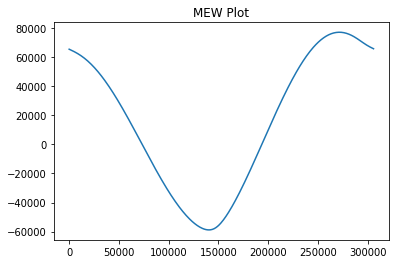

In [37]:
mew_first = mew_field[min_row:max_row]
plt.plot(mew_first.time, mew_first.principal1)
# plt.plot(mew_first.time, mew_first.principal2)
plt.title('MEW Plot')

Text(0.5, 1.0, 'SIMON Plot')

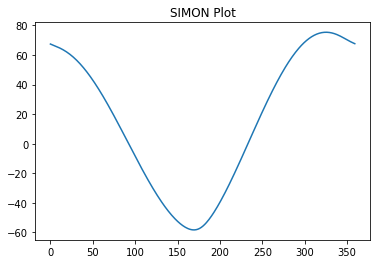

In [38]:
simon_first = simon_field[min_row:max_row]
plt.plot(simon_first.time, simon_first.stress)
plt.title('SIMON Plot')

In [10]:
mew_first

,time,lat,lon,principal1,principal2,orientation1,orientation2
0,1.000000,-259.133,287.14,65715.391378,53607.471120,0.551147,0.551147
1,853.364903,-259.133,287.14,65476.867463,52973.289954,0.580607,0.580607
2,1705.729805,-259.133,287.14,65238.754559,52302.652609,0.608178,0.608178
3,2558.094708,-259.133,287.14,64999.156606,51597.731686,0.633900,0.633900
4,3410.459610,-259.133,287.14,64756.301736,50860.586473,0.657845,0.657845
...,...,...,...,...,...,...,...
355,302590.540390,-259.133,287.14,67032.089567,56224.195171,0.371100,0.371100
356,303442.905292,-259.133,287.14,66760.680692,55813.586898,0.408809,0.408809
357,304295.270195,-259.133,287.14,66499.214892,55355.735388,0.445381,0.445381
358,305147.635097,-259.133,287.14,66246.207476,54852.344225,0.480516,0.480516


In [11]:
simon_first

,lon,lat,stress,heading,headingCategory,deltaStress,time
0,10.867,17.14,67.526469,240.578186,241.0,-0.271946,0
1,10.867,17.14,67.258340,238.760900,239.0,-0.268129,1
2,10.867,17.14,66.992071,237.051183,237.0,-0.266270,2
3,10.867,17.14,66.725717,235.449910,235.0,-0.266354,3
4,10.867,17.14,66.457409,233.955271,234.0,-0.268308,4
...,...,...,...,...,...,...,...
355,10.867,17.14,68.958941,250.980813,251.0,-0.314375,355
356,10.867,17.14,68.655077,248.774433,249.0,-0.303864,356
357,10.867,17.14,68.361138,246.611867,247.0,-0.293939,357
358,10.867,17.14,68.076065,244.514234,245.0,-0.285073,358
